In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import os
# import codecs

In [66]:
# target_url = ("/Users/devkrroy/Dev/Projects/snow/data/export3.xlsx")
target_url = ("C:/Dev/Projects/snow/data/export3.xlsx")

In [67]:
df = pd.read_excel(target_url)

In [68]:
df.info()
print(df.columns.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95373 entries, 0 to 95372
Data columns (total 28 columns):
Number                95373 non-null object
Assignment_group      95373 non-null object
Priority              95373 non-null object
State                 95373 non-null object
Category              93947 non-null object
Subcategory           61328 non-null object
Severity              95373 non-null object
Closure_CI            94492 non-null object
Location              95079 non-null object
Close_code            94559 non-null object
Configuration_item    95373 non-null object
Child_Incidents       95373 non-null int64
Contact_type          95373 non-null object
Duration              95373 non-null int64
Impact                95373 non-null object
Short_description     95373 non-null object
Created               95373 non-null datetime64[ns]
dates                 95373 non-null datetime64[ns]
date                  95373 non-null datetime64[ns]
day                   95373 non-n

In [69]:
df.head()

,Number,Assignment_group,Priority,State,Category,Subcategory,Severity,Closure_CI,Location,Close_code,...,date,day,month,dom,week,week2,cluster,cluster1,cluster_name1,cluster_name
0,INC0406604,DHE-Command Center,4 - Low,Closed,Server,Windows,3 - Low,phx-vapp-689,Corporate Office - Phoenix 1,Resolved by Event,...,2018-09-01,Saturday,September,1,1,1,1,16,volume space,threshold set disk
1,INC0406605,DH-Enterprise IT Service Cntr,4 - Low,Closed,Security,NaN,3 - Low,Network Account Lock,St Mary's Medical Center San Francisco (SMMC-SF),Account Unlock,...,2018-09-01,Saturday,September,1,1,1,48,47,login,login
2,INC0406606,DHE-RCM-AppOp-Applications,3 - Moderate,Closed,Application,Revenue Cycle,3 - Low,Soarian DM,Corporate Office - Phoenix 1,Resolved by Event,...,2018-09-01,Saturday,September,1,1,1,44,7,login,cerner
3,INC0406607,DH-Enterprise IT Service Cntr,4 - Low,Closed,Security,NaN,3 - Low,Network Account Issue,Bruceville Terrace,Password Reset,...,2018-09-01,Saturday,September,1,1,1,4,4,login,login
4,INC0406608,DH-Enterprise IT Service Cntr,4 - Low,Closed,Application,Clinical,3 - Low,Clairvia,St Mary's Medical Center San Francisco (SMMC-SF),Password Reset,...,2018-09-01,Saturday,September,1,1,1,18,36,login,login


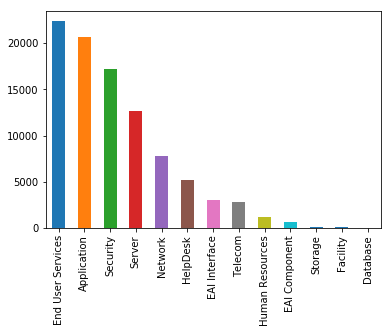

In [70]:
# plot few charts to understand the data

# Category by count - this should help understand "Number of Clusters" we should have

top_categories_df = df['Category'].value_counts()[:20]
top_categories_df.plot.bar(x = 'Category', y = 'Counts')


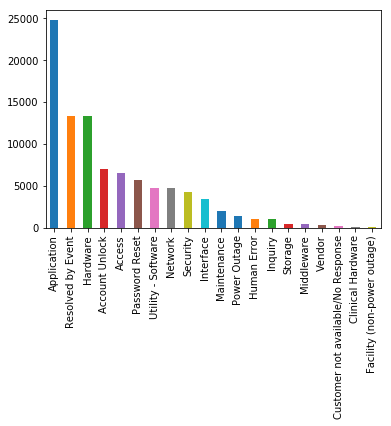

In [71]:
# Close_code by count 

top_close_code_df = df['Close_code'].value_counts()[:20]
top_close_code_df.plot.bar(x = 'Close_code', y = 'Counts')

In [72]:
# based on the 2 charts above we will go with 30 - 50 clusters of data

In [73]:
# identify the features needed
features = ['Number', 'Assignment_group', 'Priority', 'State', 'Category',
       'Subcategory', 'Severity', 'Closure_CI', 'Location', 'Close_code',
       'Configuration_item', 'Child_Incidents', 'Contact_type',
       'Duration', 'Impact', 'Short_description', 'Created']
df = df[features]

In [74]:
# use less rows for analysis, remove later
# df = df.head(10000)
print('Shape of the modified dataframe ', df.shape)

Shape of the modified dataframe  (95373, 17)


In [75]:
#Filter out some categories with instances < 50 for now , remove this filter in future
# df = df.groupby("Category").filter(lambda x: len(x) > 50)
# df = df.reset_index(drop = True)
df.Category.value_counts()

End User Services    22410
Application          20651
Security             17171
Server               12687
Network               7831
HelpDesk              5169
EAI Interface         3028
Telecom               2832
Human Resources       1224
EAI Component          697
Storage                140
Facility               100
Database                 7
Name: Category, dtype: int64

In [76]:
# nltk text preprocessing
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import contractions

from sklearn import feature_extraction
# from nltk.tag import pos_tag

stop = stopwords.words('english')
lemmer = WordNetLemmatizer()

# extend stop words
# words like issue, problem, resolve, fix - do not add more sense to the description and are common
new_stopwords = ['chw','edu','phx','vapp', 'issue', 'problem', 'resolve', 'fix']
stop.extend(new_stopwords)

# add punctuations to the stop words
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop.extend(punc)

# remove 'not' from the stop words - not defines the issue
stop.remove('not')
        
# to be tried - apply text collocations

def pre_process(text):
        
    # try to capture the IPs    
    ip_pattern = re.compile(r'((-?)([A-Za-z0-9]{1,}[-.]{1,1}){2,6}([A-Za-z0-9]*))')  
    ip = text.apply(lambda x: ' '.join(word for word in re.split('[\': (),]', x) if ip_pattern.match(word)))
    
    text = text.apply(lambda x: ' '.join(word.lower() for word in x.split()))  # lower case
       
    text = text.apply(lambda x: ' '.join(contractions.fix(word) for word in x.split()))  # replace contractions
    
    # 'not able' is a common way to report issue, replace 'not able' with 'unable'
    # also not gets removed as part of stop words
    text = text.str.replace('not able', 'unable')
    
    # there are lot of places in the description where II (2 caps I) has been used as separator
    # this gets converted to small letter (ii) with high occurance, drop these letters
    text = text.str.replace(' ii ', ' ')  # replace with spaces
    
    # '/' or '\' are usually entered to separate words, word tokenize doesn't tokenize on these
    # replace them with spaces
    text = text.str.replace('[\/-]', ' ')  # replace with spaces
    
    # "'d": changes to " would", 'disk changes to wouldisk - unwanted contraction
    # replace wouldisk with disk
    text = text.str.replace('wouldisk', 'disk')  # replace with disk    
    
    # consider complete words that contain alpha
    alpha = re.compile(r'([A-Za-z/\-]*$)')
    text = text.apply(lambda x: ' '.join(word for word in word_tokenize(x) if alpha.match(word)))
    
#     text = text.str.replace('[^A-Za-z ]', ' ')  # remove non words
    
    # user lemmer first since we have added some words in stop words
    text = text.apply(lambda x: ' '.join([lemmer.lemmatize(word, pos = 'v') for word in word_tokenize(x)]))       #lemma
    text = text.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in set(stop)]))   #stop    
    text = text.apply(lambda x: ' '.join([word for word in word_tokenize(x) if len(word) > 1 ]))  #length >1

    return (text, ip)
    
normalized = pre_process(df['Short_description'])

In [77]:
pd.options.display.max_colwidth = 100

In [78]:
print(normalized[0][:20])

0              utilization threshold set disk file system percent full
1                                    account lock unable login user id
2                                                                     
3                                               network password reset
4                   clairvia unable login password reset hduv jmoyrong
5                   network account lock unable login username jyongco
6                          error message appear open clpdayend qrgxmsg
7                           wow display leave monitor upside device id
8                                        cpu utilization threshold set
9                                            receive clpdayend qclxerr
10                                       cpu utilization threshold set
11                                       cpu utilization threshold set
12           medseries tier host ipaddress listen port charge multiple
13                                          master dsc syslog critical
14    

In [79]:
print(normalized[1][:20])

0                phx-vapp-689.chw.edu
1                                    
2                        PHX-VAPP-408
3                                    
4                                    
5                                    
6                                    
7                       10.203.212.24
8                phx-vapp-842.chw.edu
9                                    
10               phx-vapp-237.chw.edu
11               phx-vapp-238.chw.edu
12                      -10.248.84.17
13    CHW-as1-2central-dsc 10.1.5.100
14     CHW-as2-2central-dsc 10.1.5.10
15                phx-app-040.chw.edu
16                phx-app-034.chw.edu
17                                   
18                    phxdc23c-nas-07
19         CHW-as1-2west-dsc 10.1.5.6
Name: Short_description, dtype: object


In [102]:
print(normalized[0].apply(lambda x: x == '').sum())

459


In [103]:
# there are 459 cells with no terms, this isn't significant in total of 95373, lets live with it for now

In [80]:
# test results using word_tokenize
from nltk.tokenize import word_tokenize

normalized[0][:20].apply(word_tokenize)

0                 [utilization, threshold, set, disk, file, system, percent, full]
1                                         [account, lock, unable, login, user, id]
2                                                                               []
3                                                       [network, password, reset]
4                       [clairvia, unable, login, password, reset, hduv, jmoyrong]
5                       [network, account, lock, unable, login, username, jyongco]
6                               [error, message, appear, open, clpdayend, qrgxmsg]
7                               [wow, display, leave, monitor, upside, device, id]
8                                               [cpu, utilization, threshold, set]
9                                                    [receive, clpdayend, qclxerr]
10                                              [cpu, utilization, threshold, set]
11                                              [cpu, utilization, threshold, set]
12  

In [81]:
# add the processed text and extracted ips to dataframe
df['Terms'] = normalized[0]
df['IPs'] = normalized[1]

In [82]:
# this cell is just for testing regex
# import re

# print(re.split('[:\' ]', '\'phx-vapp-689.chw.edu\': Utilization is \'85.2\'. Threshold is set to \'Disk/File System/{C}/percent full >= 85\''))

# ip_pattern = re.compile(r'((-?)([A-Za-z0-9]{1,}[-.]{1,1}){2,6}([A-Za-z0-9]*))') 

# print(ip_pattern.match('phx-vapp-238.chw.edu'))
# print(ip_pattern.match('CPU Utilization is '))
# print(ip_pattern.match('85.2'))
# print(ip_pattern.match('10.250.243.2'))
# print(ip_pattern.match('-10.248.84.17'))
# print(ip_pattern.match('192.168.2.85)'))
# print(ip_pattern.match('10.1.5.100'))


# test = pd.DataFrame({'strings': ['...', 'a(b$c']})
# test.strings.str.replace('[^a-zA-Z ]', ' ')

# print('This is a test in spite.'.split())
# print(lemmer.lemmatize('acknowledgement', pos='v'))

# alpha = re.compile(r'([A-Za-z/\-]*$)')

# dk = pd.DataFrame({'sentences': ['This is a very MS4 ABCD901 \'abc.xyz.109.01\' good site. I will recommend it to others.', 
#                                  'Can you please give me a call at 9983938428. have issues with the listings.', 
#                                  'WOW / Workstation on Wheels || WOW / Workstation on Wheels Issue',
#                                  '\'phx-vapp-689.chw.edu\': Utilization is \'85.2\'. Threshold is set to \'Disk/File System/{C}/percent full >= 85',
#                                  'Clairvia/not able to login//password reset hduv done jmoyrong/issue resolved',
#                                  'God is Great/I won a lottery.',
#                                  'CIM_2_BAYDSC19_MSFCHGX:MSF19CHGX:MedSeries 4:TIER-2 P05:DESTINATION_REALTIME:No host at ipAddress -10.248.84.17, listening on port -21529. :Charges - Multiple t',
#                                  'Account Lock ||  Not able to login || user id-adeperalta001',
#                                  'good work! keep it up, couldn\'t able to login, couldn\'t connect']})

# dk['tokenized_sents']  = dk['sentences'].apply(lambda x: ' '.join(word for word in re.split('[\': (),]', x) if ip_pattern.match(word)))



# dk['tokenized_sents'] = dk['sentences'].apply(lambda x: ' '.join(word.lower() for word in x.split()))  # lower case
# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join(contractions.fix(word) for word in x.split()))  # replace contractions

# dk['tokenized_sents'] = dk['tokenized_sents'].str.replace('not able', 'unable')
# dk['tokenized_sents'] = dk['tokenized_sents'].str.replace('[\/-]', ' ')  # replace them with spaces

# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if alpha.match(word)))
# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join([lemmer.lemmatize(word, pos='v') for word in word_tokenize(x)]))       #lemma
# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in set(stop)]))   #stop

# print(dk['tokenized_sents'])

In [83]:
# define a tokenizer which returns the set of tokens in the text that it is passed
"""
def tokenize_only(text):
    # tokenize by  word 
    tokens = [word.lower() for word in nltk.word_tokenize(text) ]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens
"""    

"\ndef tokenize_only(text):\n    # tokenize by  word \n    tokens = [word.lower() for word in nltk.word_tokenize(text) ]\n    filtered_tokens = []\n    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)\n    for token in tokens:\n        if re.search('[a-zA-Z]', token):\n            filtered_tokens.append(token)\n    return filtered_tokens\n"

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(max_features=10000, max_df=0.8, min_df=0.0005,                                  
#                                   use_idf=True, tokenizer=word_tokenize, ngram_range=(1,3))

vectorizer = TfidfVectorizer(max_features = 10000,                                  
                                  use_idf = True, tokenizer = word_tokenize, stop_words = stop, ngram_range = (1,3))

%time X = vectorizer.fit_transform(df['Terms'].values)

print(X.shape)

Wall time: 13.1 s
(95373, 10000)


In [85]:
features = vectorizer.get_feature_names()
freq = sum(X).toarray()[0]
df_features = pd.DataFrame(freq, index = features, columns = ['frequency'])

# sort the terms in descending order of frequency
df_features.sort_values(by = ['frequency'], inplace = True, ascending = False)

In [86]:
# print the top 50 occurances - help decide the possible clusters
print(df_features.head(50))

                             frequency
network                    2998.580806
account                    2611.475025
unable                     2392.640253
login                      2099.636525
id                         2072.463356
network account            1997.107727
desktop                    1964.197838
lock                       1854.567170
password                   1852.940525
user                       1808.628086
account lock               1742.737733
reset                      1692.208588
unable login               1588.438526
network account lock       1568.823940
password reset             1461.933340
set                        1452.777890
threshold                  1451.112459
utilization                1412.583791
utilization threshold      1411.106628
threshold set              1410.606252
utilization threshold set  1410.423092
not                        1405.904721
phone                      1383.435059
cpu                        1220.729746
user id                  

In [87]:
# print the last 20 occurances - terms with low frequency
# how low is the frequency? do we have correct number of features
print(df_features.tail(20))

                                frequency
emr application                  2.323562
emr logician                     2.323562
centricity emr application       2.323562
emr logician centricity          2.323562
centricity emr logician          2.323562
mmr app                          2.231793
ssrnet login                     2.208802
ssi ssrnet login                 2.208802
ssrnet login transaction         2.208802
sentinel tier mft                2.189720
sentinel tier                    2.189720
platform tier document           2.123370
tier document                    2.123370
platform rectimeout occur        2.123370
platform rectimeout              2.123370
tier document enterprise         2.123370
enterprise platform rectimeout   2.123370
nvbd bca pc                      1.985173
nvbd bca                         1.985173
nvbd                             1.985173


In [88]:
print(features[100:200])

['access request adh', 'access require', 'access share', 'access take', 'access take remote', 'access transaction', 'access transaction fail', 'access unable', 'access user', 'access user id', 'access user name', 'access username', 'access vpn', 'access website', 'accessdh', 'accidentally', 'accou', 'account', 'account able', 'account access', 'account account', 'account account lock', 'account activate', 'account activation', 'account buddy', 'account buddy hduv', 'account creation', 'account creation user', 'account customer', 'account customer able', 'account customer unable', 'account deactivate', 'account dev', 'account disable', 'account disable enable', 'account disable user', 'account disable userid', 'account disablement', 'account disablement user', 'account enable', 'account enable able', 'account enable username', 'account error', 'account expire', 'account first', 'account first time', 'account forget', 'account get', 'account get lock', 'account hduv', 'account id', 'acco

In [89]:
# using elbow method to find optimum number of clusters - start with 30 clusters

# from sklearn.cluster import KMeans
# wcss = []
# for i in range(1, 31):
#     km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 1)
#     km.fit(tfidf_matrix)
#     wcss.append(km.inertia_)
    
# plt.plot(range(1,31), wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.show()

In [116]:
# run kmeans 

num_clusters = 50

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
%time y = kmeans.fit_predict(X)

# from sklearn.cluster import MiniBatchKMeans
# km = MiniBatchKMeans(n_clusters = num_clusters, init = 'k-means++', n_init = 3, init_size = 300, batch_size = 100, random_state = 1)
# %time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 8min 39s


In [117]:
df['Cluster'] = pd.DataFrame(y, columns = ['Cluster'])

In [118]:
print(df.loc[:10,['Terms', 'Cluster']])

                                                      Terms  Cluster
0   utilization threshold set disk file system percent full        9
1                         account lock unable login user id        1
2                                                                 25
3                                    network password reset        8
4        clairvia unable login password reset hduv jmoyrong       44
5        network account lock unable login username jyongco       41
6               error message appear open clpdayend qrgxmsg        2
7                wow display leave monitor upside device id       25
8                             cpu utilization threshold set       10
9                                 receive clpdayend qclxerr       25
10                            cpu utilization threshold set       10


In [119]:
# Save cluster in pickle file for future use
# import pickle

# pickle.dump(km, open('pkl/km_1.pkl', 'wb'))

In [120]:
common_words = km.cluster_centers_.argsort()[:,-1:-21:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(features[word] for word in centroid))

0 : fex power supply, lock job number, logon error, clairvia account, axway account lock, expose, index location, depart, gmhhc ap, guide, form custome, call qcmdexc end, error error consume, device id assist, assessment, elm smlb value, activate duo, allscripts scan, eq, main mgh ap
1 : extn, access host ipaddress, access journey, ext dept, accept nup, dragon, login duo user, expose, lock job number, login hduv, dsch mdf capitolafp, dsch mdf dhmf, lompocoffice mrmc, login guide user, dsch mdf, logon error, depart, fss, login remote, crmc value
2 : dhmf mdf, call system monitor, call system, dhmf idf creekside, axway account lock, call qcmdexc end, cxnmft cxnmft framework, cxnmft framework, dhmf mdf cameron, ba, aznv, mapper syslogvg, mapper syslogvg log, cut, mapper, cerner uid, blank page, icu apache outcomes, blank, count last mins
3 : heartbeat not arrive, dhmc, dhi ssrm trigger, help set, help user, dhmc ap, correctly, correct link, help customer, corrupt, help change password, dh

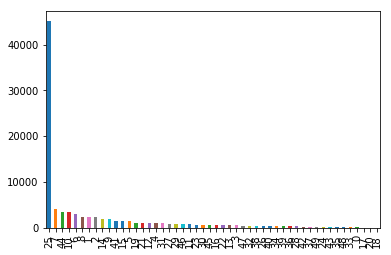

In [121]:
# lets analyze the clusters
top_clusters = df['Cluster'].value_counts()
top_clusters.plot.bar(x = 'Cluster', y = 'Counts')

In [122]:
# there is high volume for cluster 25, lets look at few to investigate
print(df[df.Cluster == 25].iloc[:20, [15,17,18, 19]])

                                                                                      Short_description  \
2                                                                              PHX-VAPP-408 - SAC0 MGH0   
7                      WOW ||  Display on the Left Monitor is upside down ||  device id-  10.203.212.24   
9   PHXASP03 CPA0701 RPG9001 received by PHCL1956 at 2100. (C D I R) CASH_ADJS  CLPDAYEND  626868 QC...   
12  CIM_2_BAYDSC19_MSFCHGX:MSF19CHGX:MedSeries 4:TIER-2 P05:DESTINATION_REALTIME:No host at ipAddres...   
17                                                   MEDITECH ALERT (HIGH)                                
18  Volume Space Nearly Full warning event on phxdc23c-nas-07:/crh1a_sleeplabs_cifs01 (Volume Space ...   
24  CIM_2_MCD95_HCLORDL:HCL99ORDL:HCCL:TIER-2:DESTINATION_REALTIME:Try 1 to receive the response fro...   
28  CIM_2_BAYDSC19_OMNADT:OMN19ADT:Omnicell:TIER-0:DESTINATION_REALTIME:Try 1 to receive the respons...   
30                                   

In [231]:
# Create mapping of ngram features into clusters, 
# save into terms map object with key as cluster name (first feature in each cluster - with 2 words)
# terms = top 20 ngram features

order_centroids = km.cluster_centers_.argsort()[:, ::-1]
df_features_map = pd.DataFrame(index = np.arange(0, num_clusters), columns=['features','key'])    

for i in range(num_clusters):
    list = [] 
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end=',')
        list.append(terms[ind])
    for ind2 in order_centroids[i, :1]:
        terms_map.key.loc[i] = terms[ind2]

    str = ', '.join(list) 
    terms_map.terms.loc[i] = str
    print()
print(terms_map.shape)

df_features = pd.DataFrame(freq, index = features, columns = ['frequency'])

# sort the terms in descending order of frequency
df_features.sort_values(by = ['frequency'], inplace = True, ascending = False)

order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
terms_map = pd.DataFrame(index=np.arange(0, num_clusters),columns=['terms','key'])    
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    #terms_map['key'] = i
    list = [] 
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end=',')
        list.append(terms[ind])
    for ind2 in order_centroids[i, :1]:
        terms_map.key.loc[i] = terms[ind2]

    str = ', '.join(list) 
    terms_map.terms.loc[i] = str
    print()
print(terms_map.shape)

Cluster 0: reset, password, reset user name, account password, account password reset, password reset user, reset user, hduv, user name, name, reset password, hduv reset, user name hduv, name hduv, password reset, network account password, user, account, hduv reset password, network,
Cluster 1: cpu utilization threshold, cpu utilization, cpu, threshold set, utilization threshold, utilization, utilization threshold set, set, threshold, medps cpu utilization, medps, medps cpu, vint, vint cpu, vint cpu utilization, viis cpu utilization, viis cpu, app cpu utilization, app cpu, viis,
Cluster 2: printer, device, login, wheel, workstation wheel, workstation, wow workstation, wow workstation wheel, reboot, wow, device reboot, mdf, status, power, file, application, sjpvh, power supply, supply, sjpvh device,
Cluster 3: error, error error, mft error, mft, tier mft, tier mft error, mft error error, tier, sftp, error error unable, error unable, suite, suite tier, error unable connect, millennium, m